In [1]:
import tools
import math
import visualization_2D as vis2D
import visualization_3D as vis3D
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import random as rd
import plotly.graph_objects as go
import plotly.express as px
import os
import sqlite3
from intermine.webservice import Service

# I- TRN download

In [2]:
#https://rdcu.be/cpoEH
#https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-74043-7/MediaObjects/41598_2020_74043_MOESM1_ESM.zip
Yeast_TRN = pd.read_csv('../results/yeast2019-full-conds-net.csv', sep='\t', header = None)
Yeast_TRN.columns = ["TF", "TG", "type", "description"]
Yeast_TRN

,TF,TG,type,description
0,ABF1,COX6,Direct Positive,N/A;N/A;N/A;Stress;Unstressed log-phase growth...
1,ABF1,RPS28B,Direct,N/A;N/A;Stress
2,ABF1,RPO26,Direct,N/A;N/A;N/A;Unstressed log-phase growth (control)
3,ABF1,HIS7,Direct Dual,N/A;In vitro;Unstressed log-phase growth (cont...
4,ABF1,"ADE5,7",Direct,N/A;Unstressed log-phase growth (control)
...,...,...,...,...
195493,PEX2,PEX2,Indirect Negative,Unstressed log-phase growth (control);Stress
195494,FYV5,ATG14,Indirect Negative,Unstressed log-phase growth (control)
195495,FYV5,ATG9,Indirect Negative,Unstressed log-phase growth (control)
195496,FYV5,ATG32,Indirect Negative,Unstressed log-phase growth (control)


In [3]:
Yeast_TRN = Yeast_TRN[Yeast_TRN.type.isin(['Direct Positive', 'Direct Dual', 'Direct Negative'])]

In [4]:
Yeast_TRN

,TF,TG,type,description
0,ABF1,COX6,Direct Positive,N/A;N/A;N/A;Stress;Unstressed log-phase growth...
3,ABF1,HIS7,Direct Dual,N/A;In vitro;Unstressed log-phase growth (cont...
5,ABF1,IPP1,Direct Positive,Unstressed log-phase growth (control);Stress;N...
10,ABF1,RPL2B,Direct Positive,Unstressed log-phase growth (control);Unstress...
13,ABF1,QCR8,Direct Positive,Stress;Unstressed log-phase growth (control);C...
...,...,...,...,...
189125,YRR1,NCE102,Direct Dual,Carbon source quality/availability;Unstressed ...
189128,YRR1,GPH1,Direct Dual,Unstressed log-phase growth (control);Unstress...
189130,YRR1,QCR2,Direct Dual,Carbon source quality/availability;Stress;Unst...
190379,MAL63,MAL62,Direct Positive,In vitro;Carbon source quality/availability


In [5]:
sql_query = \
"""SELECT Standard_gene_name, Feature_name, Chromosome, Strand
FROM SGD_features
"""

# Get all features for all gene
loci = tools.get_locus_info("../SCERE.db", sql_query)

In [6]:
print(len(Yeast_TRN.TF.unique()))
print(len(Yeast_TRN.TG.unique()))

152
3912


# II- Targets lists creation

In [ ]:
list_TF = Yeast_TRN.TF.unique()
#len(list_TF) = 220
#len(Yeast_TRN.TG.unique()) = 6886

for TF in list_TF :
    
    TG = Yeast_TRN[Yeast_TRN.TF == TF]
    TG = TG.drop(["TF", "type", "description"], axis = 1)
    
    save = TG[TG["TG"].isin(loci["Feature_name"])]
    TG = TG.merge(loci, left_on = "TG", right_on = "Standard_gene_name")
    TG = TG["Feature_name"]
    TG = TG.append(save["TG"])
    TG = pd.DataFrame(TG)
    TG.columns = ["TG"]
    TG.to_csv("../results/TF_target_TRN_2019_AandB/" + str(TF) + "_" + str(len(TG)) + "_targets.csv", 
              index = False)

# III- Cumulative distribution function and distribution histogram

## 1) For 3D distances between targets

In [7]:
def get_edges_list(gene_list, edges_list, feature_name):
    
    # Add SGDID
    feature_name = feature_name.merge(genes_list, left_on = "Feature_name", right_on = genes_list.columns[0])
    
    # Extract distances for selected genes list
    edges_list_select = edges_list[edges_list["Primary_SGDID"].isin(feature_name["Primary_SGDID"])]
    edges_list_select = edges_list_select[edges_list_select["Primary_SGDID_bis"].isin(feature_name["Primary_SGDID"])]
    edges_list_select.index = range(1, len(edges_list_select) + 1)
    
    return edges_list_select


def distri(genes_list, edges_list, feature_name):
    
    sample_number = 20
    bin_number = 60
    
    edges_list_select = get_edges_list(genes_list, edges_list, feature_name)
    x = list(edges_list_select["3D_distances"])
    H, X1 = np.histogram(x, bins = bin_number, range = (0, 200))
    F1 = np.cumsum(H)/len(x)
    
    H2 = np.zeros(bin_number)
    rd_x = []
    for i in range(0, sample_number):
        edges_list_random = edges_list.sample(n=len(edges_list_select))
        rd_x_tmp = list(edges_list_random["3D_distances"])
        H_temp, X_temp = np.histogram(rd_x_tmp, bins = bin_number, range = (0, 200))
        rd_x += rd_x_tmp
        H2 += H_temp
    H2 = H2/sample_number
    F2 = np.cumsum(H2)/sum(H2)
    
    fig, ax = plt.subplots()
    ax.hist(X1[:-1], X1, weights=H2, color="#5767FF", alpha=0.3, label="Random targets")
    ax.set_xlim(0, 200)
    plt.xlabel("3D distances", size = 16)
    ax.hist(x, bins=X1[:-1], color="#FA3824", alpha=0.3, label="TF's targets")
    plt.ylabel("Count", size = 16)
    ax2=ax.twinx()
    plt.ylabel("CDF", size = 16)
    ax2.plot(X1[:-1], F1, label="CDF (TF's targets)", color = "#FA3824")
    ax2.plot(X1[:-1], F2, label="CDF (random)", color = "#5767FF")
    ax.legend(bbox_to_anchor = (0.6, 0.9), loc="upper left")
    ax2.legend(bbox_to_anchor = (0.6, 0.7), loc="upper left")
    
    

    # Compute Kolmogorov-Smirnov test
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
    if x != []:
    #if False:
        ks_result = ks_2samp(x, rd_x)
    else:
        ks_result = None
    
    return fig, ks_result

In [8]:
%%time
adjacency_matrix = pd.read_parquet("../dashboard/static/adjacency_matrix_V4.parquet.gzip", engine='pyarrow')
edges_list = adjacency_matrix.stack().dropna().reset_index()
edges_list.rename(columns = {0: "3D_distances"}, inplace = True)
edges_list = edges_list.sort_values(by="Primary_SGDID")
edges_list

CPU times: user 1min 43s, sys: 9.68 s, total: 1min 52s
Wall time: 1min 50s


,Primary_SGDID,Primary_SGDID_bis,3D_distances
0,S000000002,S000000001,6.336724
1,S000000003,S000000001,7.244209
2,S000000003,S000000002,0.908834
3,S000000004,S000000001,8.152506
4,S000000004,S000000002,1.818592
...,...,...,...
42171397,S000178204,S000003323,102.249328
42171398,S000178204,S000003324,101.831411
42171399,S000178204,S000003325,101.253127
42171393,S000178204,S000003319,103.011933


In [9]:
print(min(edges_list["3D_distances"]))
print(max(edges_list["3D_distances"]))
print(len(edges_list))

1.4210854715202004e-14
198.97189059261615
42177520


In [ ]:
edges_list.to_csv("../results/edges_list.csv", 
               sep = "\t",
               index = False,
               columns = ["Primary_SGDID", "Primary_SGDID_bis", "3D_distances"])

In [10]:
sql_query = \
"""SELECT Primary_SGDID, Standard_gene_name, Chromosome, Feature_name, Strand, Stop_coordinate, Start_coordinate, Description
FROM SGD_features
"""

# Get all features for all gene
feature_name = tools.get_locus_info("../SCERE.db", sql_query)
feature_name

,Primary_SGDID,Standard_gene_name,Chromosome,Feature_name,Strand,Stop_coordinate,Start_coordinate,Description
0,S000002143,,1,YAL069W,W,649,335,Dubious open reading frame; unlikely to encode...
1,S000031098,,1,,W,649,335,
2,S000028594,,1,YAL068W-A,W,792,538,Dubious open reading frame; unlikely to encode...
3,S000031372,,1,,W,792,538,
5,S000028862,,1,TEL01L,C,1,801,Telomeric region on the left arm of Chromosome...
...,...,...,...,...,...,...,...,...
16384,S000030384,,9,,C,437043,438179,
16385,S000028970,,9,TEL09R,W,439888,439068,Telomeric region on the right arm of Chromosom...
16386,S000028971,,9,,W,439888,439816,Terminal telomeric repeats on the right arm of...
16387,S000028972,,9,,W,439533,439068,Telomeric X element Core sequence on the right...


CPU times: user 24.4 s, sys: 173 ms, total: 24.5 s
Wall time: 24.5 s


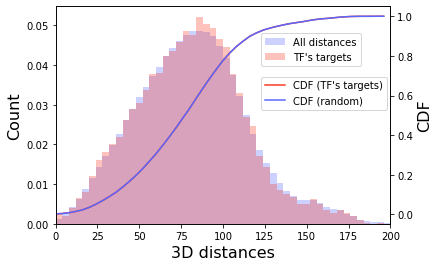

In [30]:
%%time
#test on one FT
genes_list = pd.read_csv('../results/TF_target_TRN_2019/ADR1_343_targets.csv', sep=',', header = [0])
files_names = os.listdir("../results/TF_target_TRN_2019")
file_name = 'ADR1_343_targets.csv'

sample_number = 20
bin_number = 50
    
edges_list_select = get_edges_list(genes_list, edges_list, feature_name)
x = list(edges_list_select["3D_distances"])
H, X1 = np.histogram(x, bins = bin_number, range = (0, 200))
F1 = np.cumsum(H)/len(x)

all_x = list(edges_list["3D_distances"])
H2, X = np.histogram(all_x, bins = bin_number, range = (0, 200))
F2 = np.cumsum(H)/sum(H)

H2 = H2/len(all_x)
H = H/len(x)

fig, ax = plt.subplots()
ax.hist(X1[:-1], X1, weights=H2, color="#5767FF", alpha=0.3, label="All distances")
ax.set_xlim(0, 200)
plt.xlabel("3D distances", size = 16)
ax.hist(X1[:-1], X1, weights=H, color="#FA3824", alpha=0.3, label="TF's targets")
plt.ylabel("Density", size = 16)
ax2=ax.twinx()
plt.ylabel("CDF", size = 16)
ax2.plot(X1[:-1], F1, label="CDF (TF's targets)", color = "#FA3824")
ax2.plot(X1[:-1], F2, label="CDF (random)", color = "#5767FF")
ax.legend(bbox_to_anchor = (0.6, 0.9), loc="upper left")
ax2.legend(bbox_to_anchor = (0.6, 0.7), loc="upper left")

In [ ]:
%%time
#test on one FT
genes_list = pd.read_csv('../results/TF_target_TRN_2019/ECM22_140_targets.csv', sep=',', header = [0])
files_names = os.listdir("../results/TF_target_TRN_2019")
file_name = 'ECM22_140_targets.csv'

res = distri(genes_list, edges_list, feature_name)

res[0].show()

In [ ]:
res[1].pvalue

In [ ]:
%%time

files_names = os.listdir("../results/TF_target_TRN_2019_AandB")
results = pd.DataFrame(columns = ["TF", "TF_name", "description", "targets_number", "KS_stat", "KS_pvalue"])

for file_name in files_names:
    print(file_name)
    FT_name = file_name.split('_')
    FT_name = FT_name[0]
    genes_list = pd.read_csv('../results/TF_target_TRN_2019_AandB/' + file_name, sep=',', header = [0])
    res = distri(genes_list, edges_list, feature_name)
    standard_name = FT_name
    if FT_name in feature_name["Standard_gene_name"].values:
        description = feature_name["Description"][feature_name["Standard_gene_name"] == FT_name].values[0]
    else:
        print(f"{FT_name} not in data !")
        description = None
    
    if res[1] != None:
        results = results.append({"TF": FT_name, 
                                  "TF_name": standard_name, 
                                  "description": description, 
                                  "targets_number": len(genes_list), 
                                  "KS_stat": res[1].statistic, 
                                  "KS_pvalue": res[1].pvalue}, 
                                 ignore_index=True)
    
    else:
        results = results.append({"TF": FT_name, 
                                  "TF_name": standard_name, 
                                  "description": description, 
                                  "targets_number": len(genes_list), 
                                  "KS_stat": None, 
                                  "KS_pvalue": None}, 
                                 ignore_index=True)
    
    res[0].savefig(f"../results/distri_2019_AandB/{file_name}.png")
    plt.close()

In [ ]:
#MAL63 is not localized on the genome
results.sort_values(by =["KS_pvalue"], ascending=True).reset_index()

In [ ]:
results.to_csv("../results/3D_distances_results_recapitulation_2019_BandE.csv", 
               sep = "\t",
               index = False,
               columns = ["TF", "TF_name", "description", "targets_number", "KS_stat", "KS_pvalue"])

In [ ]:
fig = px.histogram(results, x="targets_number", nbins = 100)
fig.show()

In [ ]:
fig = px.histogram(results, x="KS_pvalue", nbins = 100, range_x = (0, 1))
fig.show()

In [ ]:
fig = px.histogram(results, x="KS_stat")
#fig.show()

In [ ]:
selection = results
selection = selection[selection["targets_number"] > 40]
selection.sort_values(by =["KS_stat"], ascending=False).reset_index().loc[:20,]

## 2) Barycenters

In [ ]:
feature_name

In [ ]:
#loci 3D positions
loci_3Dloc = pd.read_csv('../results/loci_3Dloc.csv', sep='\t', header = [0])
loci_3Dloc = feature_name.merge(loci_3Dloc, left_on = "Primary_SGDID", right_on = "Primary_SGDID")
loci_3Dloc = loci_3Dloc.drop(columns = ["Primary_SGDID", "Chromosome", "Strand", 
                                        "Stop_coordinate", "Start_coordinate", "Description"])

def getbarycenter(regmod):
    bary_x = regmod["x_start"].sum()/len(regmod)
    bary_y = regmod["y_start"].sum()/len(regmod)
    bary_z = regmod["z_start"].sum()/len(regmod)
    
    return (bary_x, bary_y, bary_z)

def getFTloc(FT_name, loci_3Dloc):
    if (loci_3Dloc["Standard_gene_name"] == FT_name).sum() == 1:
        return (loci_3Dloc[loci_3Dloc["Standard_gene_name"] == FT_name]["x_start"].values[0],
                loci_3Dloc[loci_3Dloc["Standard_gene_name"] == FT_name]["y_start"].values[0],
                loci_3Dloc[loci_3Dloc["Standard_gene_name"] == FT_name]["z_start"].values[0])
    else:
        return "not in data !"

files_names = os.listdir("../results/TF_target_TRN_2019")
RES = pd.DataFrame(columns = ["TF", "distance"])

for file_name in files_names:
    FT_name = file_name.split('_')
    FT_name = FT_name[0]
    genes_list = pd.read_csv('../results/TF_target_TRN_2019/' + file_name, sep=',', header = [0])
    
    if len(genes_list) > 1:
        regmod = loci_3Dloc[loci_3Dloc["Feature_name"].isin(genes_list["TG"])]
        
        barycenter = getbarycenter(regmod)
        FTloc = getFTloc(FT_name, loci_3Dloc)
        if FTloc != "not in data !":
            dist = math.sqrt((barycenter[0] - FTloc[0]) ** 2 +
                             (barycenter[1] - FTloc[1]) ** 2 +
                             (barycenter[2] - FTloc[2]) ** 2)
        else:
            dist = None
    
        RES = RES.append({"TF": FT_name, "distance": dist}, ignore_index=True)

RES
#for each TG list
##calcul barycenter.
##get the FT position.
##calcul distance between the two.
#YAP5 and PDR1 have two mitochondrial targets, not taken into account.

In [ ]:
fig = px.histogram(RES, x="distance", nbins = 60, range_x = (0, 200))
fig.show()

## 3) For 2D chromosomal positions

In [ ]:
#BILAN
BandE = pd.read_csv('../results/3D_distances_results_recapitulation_2019_BandE.csv', sep='\t', header = [0])
B = pd.read_csv('../results/3D_distances_results_recapitulation_2019.csv', sep='\t', header = [0])

In [ ]:
BandE_filtered = BandE.sort_values(by =["KS_stat"], ascending=False).reset_index()
BandE_filtered = BandE_filtered[BandE_filtered["targets_number"] > 30]
BandE_filtered.reset_index().loc[:20,]

In [ ]:
B_filtered = B.sort_values(by =["KS_stat"], ascending=False).reset_index()
B_filtered = B_filtered[B_filtered["targets_number"] > 30]
B_filtered.reset_index().loc[:20,]

In [ ]:
#RES = RES.merge(BandE, left_on = "TF", right_on = "TF")
RES = RES.merge(B, left_on = "TF", right_on = "TF")
#144 FT with TG nb > 1
#165 FT with TG nb > 1
RES = RES.drop(columns = ["TF_name"])

In [ ]:
RES.to_csv("../results/FV_2019_B.csv", 
               sep = "\t",
               index = False,
               columns = ["TF","distance", "description", "targets_number", "KS_stat", "KS_pvalue"])